# Criando um Modelo XGBoost

Este notebook demonstra como criar e treinar um modelo XGBoost para classificação binária usando o dataset de propensão à antecipação.

## 1. Import Required Libraries

Importar as bibliotecas necessárias, incluindo XGBoost, pandas, numpy, scikit-learn e matplotlib para visualização.

In [ ]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
import xgboost as xgb

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score,
    roc_curve
)

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load and Prepare Data

Carregar o dataset normalizado do CSV e separar as features (X) da variável target (y).

In [ ]:
# Carregar os dados normalizados
df = pd.read_csv("data_normalized.csv")

# Visualizar as primeiras linhas
print("Shape do dataset:", df.shape)
print("\nPrimeiras linhas:")
df.head()

In [ ]:
# Verificar informações do dataset
print("Informações do dataset:")
print(df.info())
print("\nDistribuição da variável target:")
print(df['ANTECIPA'].value_counts())
print(f"\nProporção: {df['ANTECIPA'].value_counts(normalize=True)}")

In [ ]:
# Separar features (X) e target (y)
X = df.drop('ANTECIPA', axis=1)
y = df['ANTECIPA']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNomes das features:\n{list(X.columns)}")

In [ ]:
# Limpar nomes das colunas - remover caracteres especiais
def clean_column_names(df):
    """Remove caracteres especiais dos nomes das colunas"""
    df.columns = df.columns.str.replace('[', '', regex=False)
    df.columns = df.columns.str.replace(']', '', regex=False)
    df.columns = df.columns.str.replace('<', '', regex=False)
    df.columns = df.columns.str.replace('>', '', regex=False)
    df.columns = df.columns.str.strip()
    return df

# Aplicar limpeza
X = clean_column_names(X)

print("Nomes das colunas após limpeza:")
print(list(X.columns))

## 3. Split Data into Training and Testing Sets

Usar train_test_split para dividir os dados em conjuntos de treino e teste com proporções apropriadas.

In [ ]:
# Dividir dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Manter a proporção das classes
)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")
print(f"\nDistribuição no treino:\n{y_train.value_counts()}")
print(f"\nDistribuição no teste:\n{y_test.value_counts()}")

## 4. Create and Configure XGBoost Model

Inicializar um classificador XGBoost com parâmetros básicos como max_depth, learning_rate, n_estimators e função objetivo para classificação binária.

In [ ]:
# Criar o modelo XGBoost com parâmetros básicos
model = xgb.XGBClassifier(
    max_depth=4,                    # Profundidade máxima das árvores
    learning_rate=0.05,              # Taxa de aprendizado
    n_estimators=40,               # Número de árvores
    objective='binary:logistic',    # Objetivo: classificação binária
    eval_metric='logloss',          # Métrica de avaliação
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1                       # Usar todos os processadores
)

print("Modelo XGBoost criado com os seguintes parâmetros:")
print(model.get_params())

## 5. Train the Model

Treinar o modelo XGBoost nos dados de treino usando o método fit().

In [ ]:
# Treinar o modelo
print("Treinando o modelo...")
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50  # Mostrar progresso a cada x iterações
)
print("\nTreinamento concluído!")

In [ ]:
# Visualizar a curva de aprendizado
results = model.evals_result()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['logloss'], label='Treino')
plt.plot(results['validation_1']['logloss'], label='Teste')
plt.xlabel('Número de Iterações')
plt.ylabel('Log Loss')
plt.title('Curva de Aprendizado - Log Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Make Predictions

Usar o modelo treinado para fazer previsões no conjunto de teste, incluindo previsões de classe e probabilidades.

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

print("Primeiras 10 previsões:")
print(f"Classe prevista: {y_pred[:10]}")
print(f"Probabilidade: {y_pred_proba[:10]}")
print(f"Classe real: {y_test[:10].values}")

## 7. Evaluate Model Performance

Calcular e exibir métricas de avaliação como acurácia, precisão, recall, F1-score e matriz de confusão. Criar um relatório de classificação e visualizar a matriz de confusão.

In [ ]:
# Calcular métricas de desempenho
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 50)
print("MÉTRICAS DE DESEMPENHO DO MODELO")
print("=" * 50)
print(f"Acurácia:  {accuracy:.4f}")
print(f"Precisão:  {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("=" * 50)

In [ ]:
# Relatório de classificação completo
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, y_pred, target_names=['Não Antecipa', 'Antecipa']))

In [ ]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 5))

# Matriz de confusão
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.xticks([0.5, 1.5], ['Não Antecipa', 'Antecipa'])
plt.yticks([0.5, 1.5], ['Não Antecipa', 'Antecipa'])

# Curva ROC
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

Extrair e visualizar os scores de importância das features para entender quais variáveis contribuem mais para as previsões do modelo.

In [ ]:
# Obter importância das features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Features Mais Importantes:")
print(feature_importance.head(10))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, max_num_features=15, ax=ax, importance_type='weight')
plt.title('Importância das Features (XGBoost - Weight)')
plt.tight_layout()
plt.show()

## 9. Hyperparameter Tuning with Cross-Validation

Usar GridSearchCV ou RandomizedSearchCV para encontrar hiperparâmetros ótimos e melhorar o desempenho do modelo através de validação cruzada.

In [ ]:
# Definir grade de hiperparâmetros para busca
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print("Parâmetros para busca:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

In [ ]:
# Criar modelo base
base_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Configurar GridSearchCV
print("\nIniciando GridSearchCV...")
print("Isso pode levar alguns minutos...\n")

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,                      # 3-fold cross-validation
    scoring='roc_auc',         # Métrica de avaliação
    verbose=2,
    n_jobs=-1
)

# Executar busca (usar uma amostra menor para teste mais rápido)
grid_search.fit(X_train, y_train)

print("\nBusca concluída!")

In [ ]:
# Melhores parâmetros encontrados
print("=" * 50)
print("MELHORES HIPERPARÂMETROS ENCONTRADOS:")
print("=" * 50)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nMelhor Score (ROC-AUC): {grid_search.best_score_:.4f}")
print("=" * 50)

In [ ]:
# Treinar modelo otimizado com os melhores parâmetros
best_model = grid_search.best_estimator_

# Fazer previsões com o modelo otimizado
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Avaliar modelo otimizado
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)

print("\n" + "=" * 50)
print("COMPARAÇÃO DE DESEMPENHO")
print("=" * 50)
print(f"{'Métrica':<15} {'Modelo Base':<15} {'Modelo Otimizado':<15} {'Melhoria':<15}")
print("-" * 50)
print(f"{'Acurácia':<15} {accuracy:<15.4f} {accuracy_best:<15.4f} {(accuracy_best-accuracy)*100:>+14.2f}%")
print(f"{'Precisão':<15} {precision:<15.4f} {precision_best:<15.4f} {(precision_best-precision)*100:>+14.2f}%")
print(f"{'Recall':<15} {recall:<15.4f} {recall_best:<15.4f} {(recall_best-recall)*100:>+14.2f}%")
print(f"{'F1-Score':<15} {f1:<15.4f} {f1_best:<15.4f} {(f1_best-f1)*100:>+14.2f}%")
print(f"{'ROC-AUC':<15} {roc_auc:<15.4f} {roc_auc_best:<15.4f} {(roc_auc_best-roc_auc)*100:>+14.2f}%")
print("=" * 50)

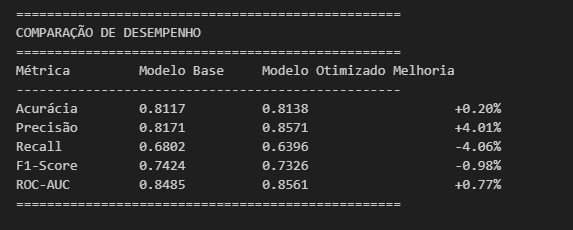

In [ ]:
# Salvar o modelo otimizado
import pickle

# Salvar modelo
with open('xgboost_model_optimized.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Salvar também as features para uso futuro
with open('model_features.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)

print("Modelo otimizado salvo como 'xgboost_model_optimized.pkl'")
print("Features salvas como 'model_features.pkl'")